# DeepRetinotopy Toolbox

####
**Author**: Fernanda Ribeiro

**Date**: 12 Nov 2025

### Citation and Resources
#### Tools included in this workflow
__deepretinotopy__:
- Ribeiro, F. L. et al. (2025). Predicting functional topography of the human visual cortex from cortical anatomy at scale. [bioRxiv](https://www.biorxiv.org/content/10.1101/2025.11.27.690210v2)

#### Dataset
__NYU Retinotopy Dataset__

Himmelberg, Marc M. and Kurzawski, Jan W. and Benson, Noah C. and Carrasco, Marisa and Winawer, Jonathan. “NYU Retinotopy dataset” 2021. [doi:10.18112/openneuro.ds003787.v1.0.1](https://github.com/OpenNeuroDatasets/ds003787.git)

## DeepRetinotopy toolbox

This interactive notebook demonstrates how to predict retinotopic maps from anatomical data using a geometric deep learning model of retinotopy. For more details about the toolbox, please check our [repository](https://github.com/felenitaribeiro/deepRetinotopy_Toolbox). The accompanying manuscript will be available soon.

Requirements:

1. freesurfer directory;
2. HCP "fs_LR-deformed_to-fsaverage" surfaces, available [here](https://github.com/Washington-University/HCPpipelines/tree/master/global/templates/standard_mesh_atlases/resample_fsaverage).


## Load Software Tools

In [6]:
%%capture 
!pip install nilearn nibabel numpy

In [7]:
# we can use module to load deepretinotopy in a specific version
import module
import os
await module.load('deepretinotopy/1.0.18')
await module.list()

['deepretinotopy/1.0.18']

In [3]:
# Request a freesurfer license and store it in your homedirectory. This is just an example - please replace with your license id:
!echo "Steffen.Bollmann@cai.uq.edu.au" > ~/.license
!echo "21029" >> ~/.license
!echo "*Cqyn12sqTCxo" >> ~/.license
!echo "FSxgcvGkNR59Y" >> ~/.license

## Download data

Let's start by downloading some data available on OpenNeuro. DeepRetinotopy only requires a minimal subset of FreeSurfer outputs, which means you can significantly reduce storage requirements by downloading only the following files per subject:

### Essential Files
```
<subject_id>/surf/
├── lh.white          # White matter surface
├── lh.pial           # Pial surface  
├── lh.sphere.reg     # Spherical surface for resampling
├── rh.white          # White matter surface
├── rh.pial           # Pial surface
└── rh.sphere.reg     # Spherical surface for resampling
```
**_Note_**: The toolbox automatically generates the midthickness surfaces and curvature data from these base files during processing. All other FreeSurfer outputs (thickness maps, parcellations, etc.) are not required for retinotopic mapping prediction.

In [8]:
!mkdir -p ./data

os.chdir('./data')
!datalad install https://github.com/OpenNeuroDatasets/ds003787.git # install NYU retinotopy dataset
os.chdir('ds003787/derivatives/freesurfer') # change directories
list_of_subs = os.listdir('.')

# download required files to run deepretinotopy
for sub in list_of_subs:
    for hemisphere in ['lh', 'rh']:
        for file in ['pial', 'white', 'sphere', 'sphere.reg', 'thickness']:
            cmd=f"""datalad get {sub}/surf/{hemisphere}.{file}""" 
            os.system(cmd)

Cloning:   0%|                             | 0.00/2.00 [00:00<?, ? candidates/s]
Enumerating: 0.00 Objects [00:00, ? Objects/s]
                                              
Counting:   0%|                               | 0.00/137k [00:00<?, ? Objects/s]
                                                                                
Compressing:   0%|                            | 0.00/113k [00:00<?, ? Objects/s]
                                                                                
Receiving:   0%|                              | 0.00/137k [00:00<?, ? Objects/s]
Receiving:  14%|███                   | 19.1k/137k [00:00<00:00, 191k Objects/s]
Receiving:  36%|███████▉              | 49.2k/137k [00:00<00:00, 230k Objects/s]
Receiving:  54%|███████████▉          | 73.9k/137k [00:00<00:00, 237k Objects/s]
Receiving:  72%|███████████████▊      | 98.5k/137k [00:00<00:00, 230k Objects/s]
Receiving:  89%|████████████████████▍  | 122k/137k [00:00<00:00, 217k Objects/s]
               

Since we have preprocessed data available, the only remaining requirements are the HCP template surfaces. 
Thus, we need to create a "templates" folder (for example, ./templates/) and download the following files from the link above:

- "fs_LR-deformed_to-fsaverage.R.sphere.32k_fs_LR.surf.gii";
- "fs_LR-deformed_to-fsaverage.L.sphere.32k_fs_LR.surf.gii";

In [9]:
# Set up paths relative to current directory
os.environ['PATH_FREESURFER_DIR'] = "."
os.environ['PATH_HCP_TEMPLATE_SURFACE'] = "../../templates"
os.environ['DATASET_NAME'] = "nyu"
os.environ['MAPS'] = "polarAngle,eccentricity"

In [10]:
# Create templates directory
os.makedirs(os.environ['PATH_HCP_TEMPLATE_SURFACE'], exist_ok=True)

In [11]:
# Download templates to the relative path
!cd $PATH_HCP_TEMPLATE_SURFACE && \
wget https://github.com/Washington-University/HCPpipelines/raw/master/global/templates/standard_mesh_atlases/resample_fsaverage/fs_LR-deformed_to-fsaverage.L.sphere.32k_fs_LR.surf.gii && \
wget https://github.com/Washington-University/HCPpipelines/raw/master/global/templates/standard_mesh_atlases/resample_fsaverage/fs_LR-deformed_to-fsaverage.R.sphere.32k_fs_LR.surf.gii

--2026-01-20 10:56:10--  https://github.com/Washington-University/HCPpipelines/raw/master/global/templates/standard_mesh_atlases/resample_fsaverage/fs_LR-deformed_to-fsaverage.L.sphere.32k_fs_LR.surf.gii
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Washington-University/HCPpipelines/master/global/templates/standard_mesh_atlases/resample_fsaverage/fs_LR-deformed_to-fsaverage.L.sphere.32k_fs_LR.surf.gii [following]
--2026-01-20 10:56:10--  https://raw.githubusercontent.com/Washington-University/HCPpipelines/master/global/templates/standard_mesh_atlases/resample_fsaverage/fs_LR-deformed_to-fsaverage.L.sphere.32k_fs_LR.surf.gii
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.1

## Running deepRetinotopy for a single subject

Here, we illustrate how to run deepRetinotopy for a single subject. Note that, if no output directory is provided, all maps are saved within each subject subdirectory in the freesurfer directory. 

In [12]:
## Process single subject without an explicit output directory
!deepRetinotopy -s $PATH_FREESURFER_DIR -t $PATH_HCP_TEMPLATE_SURFACE -d $DATASET_NAME -m $MAPS -i sub-wlsubj001

Processing single subject: sub-wlsubj001
Log files location: /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/logs
Output log: deepRetinotopy_20260120_105813_output.log
Error log: deepRetinotopy_20260120_105813_error.log
--------------------------------------------------------------------------------
DeepRetinotopy: retinotopic mapping using deep learning
--------------------------------------------------------------------------------
Log files: /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/logs/deepRetinotopy_20260120_105813_output.log and deepRetinotopy_20260120_105813_error.log
--------------------------------------------------------------------------------
Directories and parameters:

Path to FreeSurfer directory: /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer
Path to fs_LR-deformed_to

In [13]:
!ls $PATH_FREESURFER_DIR/sub-wlsubj001/deepRetinotopy

sub-wlsubj001.ROI.lh.native.label.gii
sub-wlsubj001.ROI.rh.native.label.gii
sub-wlsubj001.fs_predicted_eccentricity_lh_curvatureFeat_model.func.gii
sub-wlsubj001.fs_predicted_eccentricity_rh_curvatureFeat_model.func.gii
sub-wlsubj001.fs_predicted_polarAngle_lh_curvatureFeat_model.func.gii
sub-wlsubj001.fs_predicted_polarAngle_rh_curvatureFeat_model.func.gii
sub-wlsubj001.predicted_eccentricity_model.lh.native.func.gii
sub-wlsubj001.predicted_eccentricity_model.rh.native.func.gii
sub-wlsubj001.predicted_polarAngle_model.lh.native.func.gii
sub-wlsubj001.predicted_polarAngle_model.rh.native.func.gii


In [14]:
## Process single subject with an explicit output directory
! mkdir -p ../../../output && \
deepRetinotopy -s $PATH_FREESURFER_DIR -t $PATH_HCP_TEMPLATE_SURFACE -d $DATASET_NAME -m $MAPS -i sub-wlsubj001 -o ../../../output

Processing single subject: sub-wlsubj001
Log files location: /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/output
Output log: deepRetinotopy_20260120_111000_output.log
Error log: deepRetinotopy_20260120_111000_error.log
--------------------------------------------------------------------------------
DeepRetinotopy: retinotopic mapping using deep learning
--------------------------------------------------------------------------------
Log files: /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/output/deepRetinotopy_20260120_111000_output.log and deepRetinotopy_20260120_111000_error.log
--------------------------------------------------------------------------------
Directories and parameters:

Path to FreeSurfer directory: /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer
Path to fs_LR-deformed_to-fsaverage template surfaces: /home/jovyan/Git_repositories/

In [15]:
!ls ../../../output/sub-wlsubj001/

deepRetinotopy	surf


## Running deepRetinotopy for multiple subjects

If no subject is specified, all subjects within the FreeSurfer directory will be processed. However, for optimal speed, parallelising the processing for multiple subjects across multiple cores is preferred.

In [16]:
## Determine how many cores you have available
os.environ['NUMBER_OF_CORES'] = str(os.cpu_count() - 1)

In [17]:
%%bash

SUBJECT_LIST=(sub-wlsubj001 sub-wlsubj004 sub-wlsubj006 sub-wlsubj007)

process_subject() {
    local subject=$1
    echo "Processing subject: $subject"
    deepRetinotopy -s $PATH_FREESURFER_DIR -t $PATH_HCP_TEMPLATE_SURFACE -d $DATASET_NAME -m $MAPS -i "$subject"
}

export -f process_subject

printf "%s\n" "${SUBJECT_LIST[@]}" | xargs -P "$NUMBER_OF_CORES" -I {} bash -c 'process_subject "{}"'

Processing subject: sub-wlsubj001
Processing subject: sub-wlsubj004
Processing subject: sub-wlsubj006
Processing subject: sub-wlsubj007
Processing single subject: sub-wlsubj004
Processing single subject: sub-wlsubj001
Processing single subject: sub-wlsubj006
Processing single subject: sub-wlsubj007
Log files location: /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/logs
Output log: deepRetinotopy_20260120_111359_output.log
Error log: deepRetinotopy_20260120_111359_error.log
--------------------------------------------------------------------------------
DeepRetinotopy: retinotopic mapping using deep learning
--------------------------------------------------------------------------------
Log files: /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/logs/deepRetinotopy_20260120_111359_output.log and deepRetinotopy_20260120_111359_error.log
--------------------

** DA[1] has coordsys with intent NIFTI_INTENT_TRIANGLE (should be NIFTI_INTENT_POINTSET)
** DA[1] has coordsys with intent NIFTI_INTENT_TRIANGLE (should be NIFTI_INTENT_POINTSET)


Midthickness surface saved at /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj004/surf/lh.graymid.gii


** DA[1] has coordsys with intent NIFTI_INTENT_TRIANGLE (should be NIFTI_INTENT_POINTSET)
/opt/miniconda-latest/lib/python3.12/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /usr/lib64/libm.so.6: version `GLIBC_2.29' not found (required by /opt/miniconda-latest/lib/python3.12/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/opt/miniconda-latest/lib/python3.12/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/lib64/libm.so.6: version `GLIBC_2.29' not found (required by /opt/miniconda-latest/lib/python3.12/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


Saving /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj006/surf/lh.graymid as a surface
[sub-wlsubj006] Computing curvature...
Saving /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj007/surf/lh.graymid as a surface
[sub-wlsubj007] Computing curvature...
Saving /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj004/surf/lh.graymid as a surface
[sub-wlsubj004] Computing curvature...


total integrated curvature = -11.237*4pi (-141.203) --> 12 handles
ICI = 147.3, FI = 1471.0, variation=23704.286
writing Gaussian curvature to /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj006/surf/lh.graymid.K...total integrated curvature = -0.559*4pi (-7.022) --> 2 handles
done.
writing mean curvature to /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj006/surf/lh.graymid.H...ICI = 144.8, FI = 1382.4, variation=22337.118
writing Gaussian curvature to /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj007/surf/lh.graymid.K...done.


[sub-wlsubj006] Mid-thickness surface has been generated
[sub-wlsubj006] [Step 1.2] Preparing native surfaces for resampling...
[sub-wlsubj006] Running freesurfer-resample-prep...


done.
writing mean curvature to /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj007/surf/lh.graymid.H...done.


[sub-wlsubj007] Mid-thickness surface has been generated
[sub-wlsubj007] [Step 1.2] Preparing native surfaces for resampling...
[sub-wlsubj007] Running freesurfer-resample-prep...


total integrated curvature = -7.220*4pi (-90.731) --> 8 handles
ICI = 151.6, FI = 1563.0, variation=24939.408
writing Gaussian curvature to /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj004/surf/lh.graymid.K...done.
writing mean curvature to /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj004/surf/lh.graymid.H...done.


[sub-wlsubj004] Mid-thickness surface has been generated
[sub-wlsubj004] [Step 1.2] Preparing native surfaces for resampling...
[sub-wlsubj004] Running freesurfer-resample-prep...


Processing...


Saving /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj006/surf/lh.midthickness.surf.gii.temp35352.white.surf.gii as a surface
Saving /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj007/surf/lh.midthickness.surf.gii.temp35357.white.surf.gii as a surface
Saving /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj004/surf/lh.midthickness.surf.gii.temp35474.white.surf.gii as a surface
Saving /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj006/surf/lh.midthickness.surf.gii.temp35352.pial.surf.gii as a surface
Saving /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj007/surf/lh.midthickness.surf.gii.temp35357.pial.surf.gii 

/opt/miniconda-latest/lib/python3.12/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /usr/lib64/libm.so.6: version `GLIBC_2.29' not found (required by /opt/miniconda-latest/lib/python3.12/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/opt/miniconda-latest/lib/python3.12/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /usr/lib64/libm.so.6: version `GLIBC_2.29' not found (required by /opt/miniconda-latest/lib/python3.12/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/opt/miniconda-latest/lib/python3.12/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/lib64/libm.so.6: version `GLIBC_2.29' not found (required by /opt/miniconda-latest/lib/

[Step 2] STARTING INFERENCE
Prediction type: polarAngle
Hemisphere: lh
Dataset: nyu
Stimulus: original
Output mode: In-place (within FreeSurfer directory structure)
Output directory not specified, using input path: /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer
Data path: /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer
Temporary processed directory: /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/processed_35174_a7574882_53333
Processing single subject: sub-wlsubj001
Found 1 subjects to process: ['sub-wlsubj001']
Final subject list after validation: 1 subjects: ['sub-wlsubj001']
[Step 2.1] Loading the dataset...
Dataset loaded successfully
Dataset loading time: 0.30 minutes
[Step 2.2] Generating predictions with pre-trained models...
Loading model 1/1...
Using device: cpu
Loading model from

Done!


[Step 3] Resampling predictions to native space...
Model: model
Map: polarAngle
Hemisphere: lh
Processing single subject: sub-wlsubj001
Output mode: In-place (within FreeSurfer directory structure)
Processing subject: sub-wlsubj001
=== Processing Step 3 for subject: sub-wlsubj001 ===
[sub-wlsubj001] Using FreeSurfer directory: /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj001/deepRetinotopy
[sub-wlsubj001] Resampling ROI from fsaverage to native space for the left hemisphere...
[sub-wlsubj001] Resampling predicted map from fsaverage to native space for the left hemisphere...


[sub-wlsubj001] Transforming polar angle map of the left hemisphere...
[sub-wlsubj001] Applying mask to the predicted map of the left hemisphere...


=== Subject sub-wlsubj001 completed in 0 minutes ===

[Step 3] COMPLETED!
Total execution time: 0m 6s
Subject processed: sub-wlsubj001
Map: polarAngle | Model: model | Hemisphere: lh
Output location: In-place within FreeSurfer directory
polarAngle resampling completed for lh hemisphere
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Map: eccentricity
--------------------------------------------------------------------------------
[Step 2] Retinotopy prediction...


/opt/miniconda-latest/lib/python3.12/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /usr/lib64/libm.so.6: version `GLIBC_2.29' not found (required by /opt/miniconda-latest/lib/python3.12/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/opt/miniconda-latest/lib/python3.12/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/lib64/libm.so.6: version `GLIBC_2.29' not found (required by /opt/miniconda-latest/lib/python3.12/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
Processing...


[Step 2] STARTING INFERENCE
Prediction type: polarAngle
Hemisphere: lh
Dataset: nyu
Stimulus: original
Output mode: In-place (within FreeSurfer directory structure)
Output directory not specified, using input path: /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer
Data path: /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer
Temporary processed directory: /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/processed_35761_54b73087_73146
Processing single subject: sub-wlsubj006
Found 1 subjects to process: ['sub-wlsubj006']
Final subject list after validation: 1 subjects: ['sub-wlsubj006']
[Step 2.1] Loading the dataset...
Dataset loaded successfully
Dataset loading time: 0.30 minutes
[Step 2.2] Generating predictions with pre-trained models...
Loading model 1/1...
Using device: cpu
Loading model from

[Step 3] Resampling predictions to native space...
Model: model
Map: polarAngle
Hemisphere: lh
Processing single subject: sub-wlsubj004
Output mode: In-place (within FreeSurfer directory structure)
Processing subject: sub-wlsubj004
=== Processing Step 3 for subject: sub-wlsubj004 ===
[sub-wlsubj004] Using FreeSurfer directory: /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj004/deepRetinotopy


[sub-wlsubj004] Resampling ROI from fsaverage to native space for the left hemisphere...
[sub-wlsubj006] Transforming polar angle map of the left hemisphere...
[sub-wlsubj007] Transforming polar angle map of the left hemisphere...
[sub-wlsubj006] Applying mask to the predicted map of the left hemisphere...


=== Subject sub-wlsubj006 completed in 0 minutes ===

[Step 3] COMPLETED!
Total execution time: 0m 4s
Subject processed: sub-wlsubj006
Map: polarAngle | Model: model | Hemisphere: lh
Output location: In-place within FreeSurfer directory
polarAngle resampling completed for lh hemisphere
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Map: eccentricity
--------------------------------------------------------------------------------
[Step 2] Retinotopy prediction...
[sub-wlsubj007] Applying mask to the predicted map of the left hemisphere...


=== Subject sub-wlsubj007 completed in 0 minutes ===

[Step 3] COMPLETED!
Total execution time: 0m 5s
Subject processed: sub-wlsubj007
Map: polarAngle | Model: model | Hemisphere: lh
Output location: In-place within FreeSurfer directory
polarAngle resampling completed for lh hemisphere
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Map: eccentricity
--------------------------------------------------------------------------------
[Step 2] Retinotopy prediction...
[sub-wlsubj004] Resampling predicted map from fsaverage to native space for the left hemisphere...


[sub-wlsubj004] Transforming polar angle map of the left hemisphere...


/opt/miniconda-latest/lib/python3.12/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /usr/lib64/libm.so.6: version `GLIBC_2.29' not found (required by /opt/miniconda-latest/lib/python3.12/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/opt/miniconda-latest/lib/python3.12/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /usr/lib64/libm.so.6: version `GLIBC_2.29' not found (required by /opt/miniconda-latest/lib/python3.12/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "


[sub-wlsubj004] Applying mask to the predicted map of the left hemisphere...


=== Subject sub-wlsubj004 completed in 0 minutes ===

[Step 3] COMPLETED!
Total execution time: 0m 4s
Subject processed: sub-wlsubj004
Map: polarAngle | Model: model | Hemisphere: lh
Output location: In-place within FreeSurfer directory
polarAngle resampling completed for lh hemisphere
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Map: eccentricity
--------------------------------------------------------------------------------
[Step 2] Retinotopy prediction...


/opt/miniconda-latest/lib/python3.12/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/lib64/libm.so.6: version `GLIBC_2.29' not found (required by /opt/miniconda-latest/lib/python3.12/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
/opt/miniconda-latest/lib/python3.12/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/lib64/libm.so.6: version `GLIBC_2.29' not found (required by /opt/miniconda-latest/lib/python3.12/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
Done!
Processing...
Processing...
/opt/miniconda-latest/lib/python3.12/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /usr/lib64/libm.so.6: version `GLIBC_2.29'

[Step 2] STARTING INFERENCE
Prediction type: eccentricity
Hemisphere: lh
Dataset: nyu
Stimulus: original
Output mode: In-place (within FreeSurfer directory structure)
Output directory not specified, using input path: /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer
Data path: /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer
Temporary processed directory: /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/processed_36230_c4acce7c_5629
Processing single subject: sub-wlsubj001
Found 1 subjects to process: ['sub-wlsubj001']
Final subject list after validation: 1 subjects: ['sub-wlsubj001']
[Step 2.1] Loading the dataset...
Dataset loaded successfully
Dataset loading time: 0.30 minutes
[Step 2.2] Generating predictions with pre-trained models...
Loading model 1/1...
Using device: cpu
Loading model fro

Done!


[Step 3] Resampling predictions to native space...
Model: model
Map: eccentricity
Hemisphere: lh
Processing single subject: sub-wlsubj001
Output mode: In-place (within FreeSurfer directory structure)
Processing subject: sub-wlsubj001
=== Processing Step 3 for subject: sub-wlsubj001 ===
[sub-wlsubj001] Using FreeSurfer directory: /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj001/deepRetinotopy
[sub-wlsubj001] Resampling ROI from fsaverage to native space for the left hemisphere...
[sub-wlsubj001] Resampling predicted map from fsaverage to native space for the left hemisphere...


[sub-wlsubj001] Applying mask to the predicted map of the left hemisphere...


=== Subject sub-wlsubj001 completed in 0 minutes ===

[Step 3] COMPLETED!
Total execution time: 0m 5s
Subject processed: sub-wlsubj001
Map: eccentricity | Model: model | Hemisphere: lh
Output location: In-place within FreeSurfer directory
eccentricity resampling completed for lh hemisphere
--------------------------------------------------------------------------------
Processing right hemisphere
--------------------------------------------------------------------------------
[Step 1] Generating mid-thickness surface and curvature data...
Hemisphere: rh
Processing single subject: sub-wlsubj001
Output mode: In-place (within FreeSurfer directory structure)
Processing subject: sub-wlsubj001
=== Processing Step 1 for subject: sub-wlsubj001 ===
[sub-wlsubj001] Using FreeSurfer directory: /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj001/surf
[sub-wlsubj001] Fast mode enabled.
[sub-wlsubj001] [Step 1.1] Generating 

/opt/miniconda-latest/lib/python3.12/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /usr/lib64/libm.so.6: version `GLIBC_2.29' not found (required by /opt/miniconda-latest/lib/python3.12/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/opt/miniconda-latest/lib/python3.12/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/lib64/libm.so.6: version `GLIBC_2.29' not found (required by /opt/miniconda-latest/lib/python3.12/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
Processing...


[Step 2] STARTING INFERENCE
Prediction type: eccentricity
Hemisphere: lh
Dataset: nyu
Stimulus: original
Output mode: In-place (within FreeSurfer directory structure)
Output directory not specified, using input path: /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer
Data path: /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer
Temporary processed directory: /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/processed_36571_e73ea1c4_24011
Processing single subject: sub-wlsubj006
Found 1 subjects to process: ['sub-wlsubj006']
Final subject list after validation: 1 subjects: ['sub-wlsubj006']
[Step 2.1] Loading the dataset...
Dataset loaded successfully
Dataset loading time: 0.30 minutes
[Step 2.2] Generating predictions with pre-trained models...
Loading model 1/1...
Using device: cpu
Loading model fr

[sub-wlsubj004] Resampling predicted map from fsaverage to native space for the left hemisphere...


[sub-wlsubj006] Applying mask to the predicted map of the left hemisphere...


[sub-wlsubj007] Applying mask to the predicted map of the left hemisphere...
=== Subject sub-wlsubj006 completed in 0 minutes ===

[Step 3] COMPLETED!
Total execution time: 0m 6s
Subject processed: sub-wlsubj006
Map: eccentricity | Model: model | Hemisphere: lh
Output location: In-place within FreeSurfer directory
eccentricity resampling completed for lh hemisphere
--------------------------------------------------------------------------------
Processing right hemisphere
--------------------------------------------------------------------------------
[Step 1] Generating mid-thickness surface and curvature data...
Hemisphere: rh
Processing single subject: sub-wlsubj006
Output mode: In-place (within FreeSurfer directory structure)
Processing subject: sub-wlsubj006
=== Processing Step 1 for subject: sub-wlsubj006 ===
[sub-wlsubj006] Using FreeSurfer directory: /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj006/s

=== Subject sub-wlsubj007 completed in 0 minutes ===

[Step 3] COMPLETED!
Total execution time: 0m 6s
Subject processed: sub-wlsubj007
Map: eccentricity | Model: model | Hemisphere: lh
Output location: In-place within FreeSurfer directory
eccentricity resampling completed for lh hemisphere
--------------------------------------------------------------------------------
Processing right hemisphere
--------------------------------------------------------------------------------
[Step 1] Generating mid-thickness surface and curvature data...
Hemisphere: rh
Processing single subject: sub-wlsubj007
Output mode: In-place (within FreeSurfer directory structure)
Processing subject: sub-wlsubj007
=== Processing Step 1 for subject: sub-wlsubj007 ===
[sub-wlsubj007] Using FreeSurfer directory: /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj007/surf
[sub-wlsubj007] Fast mode enabled.
[sub-wlsubj007] [Step 1.1] Generating 

=== Subject sub-wlsubj004 completed in 0 minutes ===

[Step 3] COMPLETED!
Total execution time: 0m 6s
Subject processed: sub-wlsubj004
Map: eccentricity | Model: model | Hemisphere: lh
Output location: In-place within FreeSurfer directory
eccentricity resampling completed for lh hemisphere
--------------------------------------------------------------------------------
Processing right hemisphere
--------------------------------------------------------------------------------
[Step 1] Generating mid-thickness surface and curvature data...
Hemisphere: rh
Processing single subject: sub-wlsubj004
Output mode: In-place (within FreeSurfer directory structure)
Processing subject: sub-wlsubj004
=== Processing Step 1 for subject: sub-wlsubj004 ===
[sub-wlsubj004] Using FreeSurfer directory: /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj004/surf
[sub-wlsubj004] Fast mode enabled.
[sub-wlsubj004] [Step 1.1] Generating 

Done!


Saving /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj007/surf/rh.white.gii as a surface
Saving /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj004/surf/rh.white.gii as a surface
Saving /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj006/surf/rh.pial.gii as a surface
[sub-wlsubj006] Generating midthickness surface...
Saving /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj007/surf/rh.pial.gii as a surface
[sub-wlsubj007] Generating midthickness surface...
Midthickness surface saved at /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj006/surf/rh.graymid.gii
Midthickness surface saved at /home/jovyan/Git_repositorie

** DA[1] has coordsys with intent NIFTI_INTENT_TRIANGLE (should be NIFTI_INTENT_POINTSET)
** DA[1] has coordsys with intent NIFTI_INTENT_TRIANGLE (should be NIFTI_INTENT_POINTSET)


Saving /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj004/surf/rh.pial.gii as a surface
[sub-wlsubj004] Generating midthickness surface...
Saving /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj007/surf/rh.graymid as a surface
[sub-wlsubj007] Computing curvature...
Saving /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj006/surf/rh.graymid as a surface
[sub-wlsubj006] Computing curvature...
Midthickness surface saved at /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj004/surf/rh.graymid.gii


** DA[1] has coordsys with intent NIFTI_INTENT_TRIANGLE (should be NIFTI_INTENT_POINTSET)
total integrated curvature = -0.184*4pi (-2.317) --> 1 handles


Saving /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj004/surf/rh.graymid as a surface
[sub-wlsubj004] Computing curvature...


ICI = 151.2, FI = 1466.0, variation=23585.355
writing Gaussian curvature to /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj007/surf/rh.graymid.K...done.
writing mean curvature to /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj007/surf/rh.graymid.H...done.
total integrated curvature = -10.888*4pi (-136.823) --> 12 handles
ICI = 152.0, FI = 1487.7, variation=24085.999


[sub-wlsubj007] Mid-thickness surface has been generated
[sub-wlsubj007] [Step 1.2] Preparing native surfaces for resampling...
[sub-wlsubj007] Running freesurfer-resample-prep...


writing Gaussian curvature to /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj006/surf/rh.graymid.K...done.
writing mean curvature to /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj006/surf/rh.graymid.H...done.


[sub-wlsubj006] Mid-thickness surface has been generated
[sub-wlsubj006] [Step 1.2] Preparing native surfaces for resampling...
[sub-wlsubj006] Running freesurfer-resample-prep...
Saving /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj006/surf/rh.midthickness.surf.gii.temp37590.white.surf.gii as a surface
Saving /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj007/surf/rh.midthickness.surf.gii.temp37560.white.surf.gii as a surface


total integrated curvature = -8.002*4pi (-100.554) --> 9 handles
ICI = 152.9, FI = 1618.7, variation=25701.339
writing Gaussian curvature to /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj004/surf/rh.graymid.K...done.
writing mean curvature to /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj004/surf/rh.graymid.H...done.


[sub-wlsubj004] Mid-thickness surface has been generated
[sub-wlsubj004] [Step 1.2] Preparing native surfaces for resampling...
[sub-wlsubj004] Running freesurfer-resample-prep...
Saving /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj006/surf/rh.midthickness.surf.gii.temp37590.pial.surf.gii as a surface
Saving /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj007/surf/rh.midthickness.surf.gii.temp37560.pial.surf.gii as a surface
Saving /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj004/surf/rh.midthickness.surf.gii.temp37684.white.surf.gii as a surface
Saving /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/sub-wlsubj007/surf/rh.sphere.reg.surf.gii as a surface
Saving /home/jovyan/Git_repositories/

/opt/miniconda-latest/lib/python3.12/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /usr/lib64/libm.so.6: version `GLIBC_2.29' not found (required by /opt/miniconda-latest/lib/python3.12/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/opt/miniconda-latest/lib/python3.12/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /usr/lib64/libm.so.6: version `GLIBC_2.29' not found (required by /opt/miniconda-latest/lib/python3.12/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/opt/miniconda-latest/lib/python3.12/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/lib64/libm.so.6: version `GLIBC_2.29' not found (required by /opt/miniconda-latest/lib/

[sub-wlsubj004] Data resampling complete
=== Subject sub-wlsubj004 completed in 0 minutes ===

[Step 1] COMPLETED!
Total execution time: 0m 25s
Subject processed: sub-wlsubj004
Output location: In-place within FreeSurfer directory
--------------------------------------------------------------------------------
Map: polarAngle
--------------------------------------------------------------------------------
[Step 2] Retinotopy prediction...
[sub-wlsubj001] Resampling predicted map from fsaverage to native space for the right hemisphere...


[sub-wlsubj001] Applying mask to the predicted map of the right hemisphere...


=== Subject sub-wlsubj001 completed in 0 minutes ===

[Step 3] COMPLETED!
Total execution time: 0m 4s
Subject processed: sub-wlsubj001
Map: polarAngle | Model: model | Hemisphere: rh
Output location: In-place within FreeSurfer directory
polarAngle resampling completed for rh hemisphere
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Map: eccentricity
--------------------------------------------------------------------------------
[Step 2] Retinotopy prediction...


Processing...
Processing...
/opt/miniconda-latest/lib/python3.12/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /usr/lib64/libm.so.6: version `GLIBC_2.29' not found (required by /opt/miniconda-latest/lib/python3.12/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/opt/miniconda-latest/lib/python3.12/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/lib64/libm.so.6: version `GLIBC_2.29' not found (required by /opt/miniconda-latest/lib/python3.12/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
/opt/miniconda-latest/lib/python3.12/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /usr/lib64/libm.so.6: version `GLIBC_2.29' not found (requi

[Step 2] STARTING INFERENCE
Prediction type: polarAngle
Hemisphere: rh
Dataset: nyu
Stimulus: original
Output mode: In-place (within FreeSurfer directory structure)
Output directory not specified, using input path: /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer
Data path: /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer
Temporary processed directory: /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/processed_37965_8f14f7e1_2285
Processing single subject: sub-wlsubj007
Found 1 subjects to process: ['sub-wlsubj007']
Final subject list after validation: 1 subjects: ['sub-wlsubj007']
[Step 2.1] Loading the dataset...
Dataset loaded successfully
Dataset loading time: 0.30 minutes
[Step 2.2] Generating predictions with pre-trained models...
Loading model 1/1...
Using device: cpu
Loading model from:

[Step 2] STARTING INFERENCE
Prediction type: eccentricity
Hemisphere: rh
Dataset: nyu
Stimulus: original
Output mode: In-place (within FreeSurfer directory structure)
Output directory not specified, using input path: /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer
Data path: /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer
Temporary processed directory: /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/processed_38253_8fbad016_6291
Processing single subject: sub-wlsubj001
Found 1 subjects to process: ['sub-wlsubj001']
Final subject list after validation: 1 subjects: ['sub-wlsubj001']
[Step 2.1] Loading the dataset...
Dataset loaded successfully
Dataset loading time: 0.30 minutes
[Step 2.2] Generating predictions with pre-trained models...
Loading model 1/1...
Using device: cpu
Loading model fro

=== Subject sub-wlsubj007 completed in 0 minutes ===

[Step 3] COMPLETED!
Total execution time: 0m 5s
Subject processed: sub-wlsubj007
Map: polarAngle | Model: model | Hemisphere: rh
Output location: In-place within FreeSurfer directory
polarAngle resampling completed for rh hemisphere
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Map: eccentricity
--------------------------------------------------------------------------------
[Step 2] Retinotopy prediction...
=== Subject sub-wlsubj006 completed in 0 minutes ===

[Step 3] COMPLETED!
Total execution time: 0m 5s
Subject processed: sub-wlsubj006
Map: polarAngle | Model: model | Hemisphere: rh
Output location: In-place within FreeSurfer directory
polarAngle resampling completed for rh hemisphere
--------------------------------------------------------------------------------
--------------------------------------------------

[sub-wlsubj001] Resampling predicted map from fsaverage to native space for the right hemisphere...


[sub-wlsubj004] Applying mask to the predicted map of the right hemisphere...


=== Subject sub-wlsubj004 completed in 0 minutes ===

[Step 3] COMPLETED!
Total execution time: 0m 5s
Subject processed: sub-wlsubj004
Map: polarAngle | Model: model | Hemisphere: rh
Output location: In-place within FreeSurfer directory
polarAngle resampling completed for rh hemisphere
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Map: eccentricity
--------------------------------------------------------------------------------
[Step 2] Retinotopy prediction...


/opt/miniconda-latest/lib/python3.12/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /usr/lib64/libm.so.6: version `GLIBC_2.29' not found (required by /opt/miniconda-latest/lib/python3.12/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/opt/miniconda-latest/lib/python3.12/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /usr/lib64/libm.so.6: version `GLIBC_2.29' not found (required by /opt/miniconda-latest/lib/python3.12/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/opt/miniconda-latest/lib/python3.12/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/lib64/libm.so.6: version `GLIBC_2.29' not found (required by /opt/miniconda-latest/lib/

[sub-wlsubj001] Applying mask to the predicted map of the right hemisphere...


=== Subject sub-wlsubj001 completed in 0 minutes ===

[Step 3] COMPLETED!
Total execution time: 0m 5s
Subject processed: sub-wlsubj001
Map: eccentricity | Model: model | Hemisphere: rh
Output location: In-place within FreeSurfer directory
eccentricity resampling completed for rh hemisphere
--------------------------------------------------------------------------------
Execution completed!


/opt/miniconda-latest/lib/python3.12/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /usr/lib64/libm.so.6: version `GLIBC_2.29' not found (required by /opt/miniconda-latest/lib/python3.12/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/opt/miniconda-latest/lib/python3.12/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/lib64/libm.so.6: version `GLIBC_2.29' not found (required by /opt/miniconda-latest/lib/python3.12/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
Processing...
Processing...
Processing...
Done!
Done!
Done!


[Step 2] STARTING INFERENCE
Prediction type: eccentricity
Hemisphere: rh
Dataset: nyu
Stimulus: original
Output mode: In-place (within FreeSurfer directory structure)
Output directory not specified, using input path: /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer
Data path: /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer
Temporary processed directory: /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/data/ds003787/derivatives/freesurfer/processed_38737_9e672a03_54008
Processing single subject: sub-wlsubj006
Found 1 subjects to process: ['sub-wlsubj006']
Final subject list after validation: 1 subjects: ['sub-wlsubj006']
[Step 2.1] Loading the dataset...
Dataset loaded successfully
Dataset loading time: 0.30 minutes
[Step 2.2] Generating predictions with pre-trained models...
Loading model 1/1...
Using device: cpu
Loading model fr

[sub-wlsubj004] Resampling predicted map from fsaverage to native space for the right hemisphere...


[sub-wlsubj007] Applying mask to the predicted map of the right hemisphere...


[sub-wlsubj006] Applying mask to the predicted map of the right hemisphere...
=== Subject sub-wlsubj007 completed in 0 minutes ===

[Step 3] COMPLETED!
Total execution time: 0m 5s
Subject processed: sub-wlsubj007
Map: eccentricity | Model: model | Hemisphere: rh
Output location: In-place within FreeSurfer directory
eccentricity resampling completed for rh hemisphere
--------------------------------------------------------------------------------
Execution completed!


=== Subject sub-wlsubj006 completed in 0 minutes ===

[Step 3] COMPLETED!
Total execution time: 0m 5s
Subject processed: sub-wlsubj006
Map: eccentricity | Model: model | Hemisphere: rh
Output location: In-place within FreeSurfer directory
eccentricity resampling completed for rh hemisphere
--------------------------------------------------------------------------------
Execution completed!
[sub-wlsubj004] Applying mask to the predicted map of the right hemisphere...


=== Subject sub-wlsubj004 completed in 0 minutes ===

[Step 3] COMPLETED!
Total execution time: 0m 6s
Subject processed: sub-wlsubj004
Map: eccentricity | Model: model | Hemisphere: rh
Output location: In-place within FreeSurfer directory
eccentricity resampling completed for rh hemisphere
--------------------------------------------------------------------------------
Execution completed!


In [18]:
!ls ./sub-wlsubj004/deepRetinotopy

sub-wlsubj004.ROI.lh.native.label.gii
sub-wlsubj004.ROI.rh.native.label.gii
sub-wlsubj004.fs_predicted_eccentricity_lh_curvatureFeat_model.func.gii
sub-wlsubj004.fs_predicted_eccentricity_rh_curvatureFeat_model.func.gii
sub-wlsubj004.fs_predicted_polarAngle_lh_curvatureFeat_model.func.gii
sub-wlsubj004.fs_predicted_polarAngle_rh_curvatureFeat_model.func.gii
sub-wlsubj004.predicted_eccentricity_model.lh.native.func.gii
sub-wlsubj004.predicted_eccentricity_model.rh.native.func.gii
sub-wlsubj004.predicted_polarAngle_model.lh.native.func.gii
sub-wlsubj004.predicted_polarAngle_model.rh.native.func.gii


## Maps visualization

Finally, we can visualize the predicted maps in the individual's native space using nilearn.

In [19]:
from nilearn import plotting
from ipywidgets import Dropdown, interact
import nibabel as nib
import numpy as np
from IPython.display import display


def plot_data(subject, retinotopic_map):
    background = np.array(nib.load(f"./{subject}/surf/lh.graymid.H.gii").agg_data())[:]
    background[background < 0] = -1
    background[background > 1] = 1
    threshold = 1
    data = np.array(nib.load(f"./{subject}/deepRetinotopy/{subject}.predicted_{retinotopic_map}_model.lh.native.func.gii").agg_data())[:]
    data[data != 0] = data[data != 0] + threshold
    if retinotopic_map == 'eccentricity':
        max_value = 8
    else: 
        max_value = 360
    view = plotting.view_surf(
        surf_mesh=f"./{subject}/surf/lh.midthickness.surf.gii",
        surf_map=np.reshape(data[:], (-1)),
        cmap="gist_rainbow_r", black_bg=False, symmetric_cmap=False, bg_map = background,
        threshold=threshold, vmax=max_value + threshold, vmin = threshold)
    return view


In [20]:
subjects = ['sub-wlsubj001', 'sub-wlsubj004', 'sub-wlsubj006', 'sub-wlsubj007']
retinotopic_maps = ['eccentricity', 'polarAngle']

@interact(subject = subjects, retinotopic_map = retinotopic_maps)
def plot1(subject, retinotopic_map):
    view = plot_data(subject, retinotopic_map)
    display(view)

interactive(children=(Dropdown(description='subject', options=('sub-wlsubj001', 'sub-wlsubj004', 'sub-wlsubj00…

### Eccentricity Map

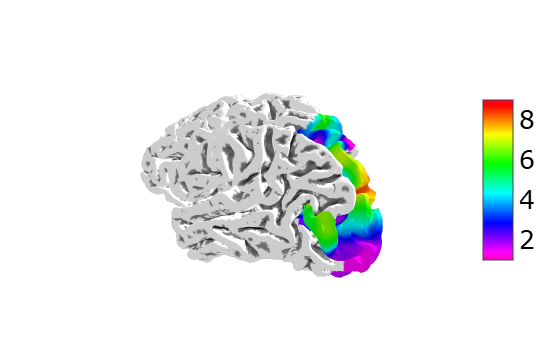

In [27]:
from IPython.display import Image, display, Markdown

display(Markdown("### Eccentricity Map"))
Image(filename='../../../../../../static/examples/functional_imaging/deepretinotopy/deepretinotopy_eccentricity.png')

### Polar Angle Map

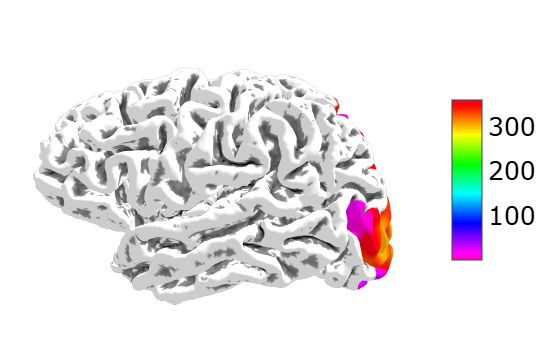

In [28]:
display(Markdown("### Polar Angle Map"))
Image(filename='../../../../../../static/examples/functional_imaging/deepretinotopy/deepretinotopy_polarAngle.png')

#### Dependencies in Jupyter/Python
- Using the package [watermark](https://github.com/rasbt/watermark) to document system environment and software versions used in this notebook

In [27]:
%load_ext watermark

%watermark
%watermark --iversions

Last updated: 2025-11-13T00:57:44.290157+00:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.16.1

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 5.4.0-204-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

nilearn   : 0.11.1
ipywidgets: 8.1.2
numpy     : 2.2.4
IPython   : 8.16.1
nibabel   : 5.3.2

